# Test with real SCADA data

In [1]:
import logging
import os
from pathlib import Path

from dotenv import load_dotenv

import gpytorch

from matplotlib import pyplot as plt

import numpy as np

import pandas as pd

import seaborn as sns

import torch

import xarray as xr


%load_ext autoreload
%autoreload 2

# Logger
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)s: %(message)s',
    level=logging.INFO,
    datefmt='%I:%M:%S'
)

# Load dotenv
_ = load_dotenv()


# DEFAULT
DATA_FOLDER = Path(os.getenv('BASE')) / 'data'

In [2]:
from sklearn.preprocessing import StandardScaler


# PACKAGE IMPORTS
from gp_sand.gp import SparseHSGPRegressor
from gp_sand.utils import (
    compute_rmse,
    compute_rmse_norm,
    resample_df
)


# HELPERS
def tanh(x, a, b, c, d):
    return c * np.tanh((x - a) / b) + d

## Load data

In [3]:
ds = (
    xr.load_dataset(DATA_FOLDER / 'turb.nc')
    .pipe(lambda ds: (
        ds.assign(
            ws_norm=ds['ws_corr'] / 10,
            ti=ds['ws_std_corr'] / ds['ws_corr'],
        )
    ))
    .pipe(lambda ds: (
        ds.assign(
            is_analysis=(
                ds['normal_op']
                & ds['no_close_wake']
                & ds['is_steady_prod']
                & (ds['gen_speed_norm'] <= 0.95)
                & (.2 <= ds['gen_speed_norm'])
                & (ds['ws_corr'] <= 10)
            )
        )
    ))
)
ds

<xarray.Dataset> Size: 2GB
Dimensions:         (wt: 116, time: 102932)
Coordinates:
  * wt              (wt) <U7 3kB 'WTG-001' 'WTG-002' ... 'WTG-117' 'WTG-118'
  * time            (time) datetime64[ns] 823kB 2022-02-06T06:00:00 ... 2024-...
Data variables: (12/35)
    ws_avg          (wt, time) float64 96MB 3.305 3.569 5.235 ... 7.118 7.014
    ws_corr         (time, wt) float64 96MB 4.149 4.709 4.437 ... 7.053 7.051
    ws_std_corr     (wt, time) float64 96MB 1.1 0.8873 0.9222 ... 0.8457 0.9124
    nac_pos_avg     (wt, time) float64 96MB 225.6 249.0 253.3 ... 188.4 185.2
    yaw_calibrated  (wt, time) float64 96MB 202.8 226.3 230.5 ... 236.8 233.6
    yaw_err_avg     (wt, time) float64 96MB 7.717 -1.323 1.742 ... -2.308 -1.902
    ...              ...
    is_train        (wt, time) bool 12MB False True False ... False False False
    is_analysis     (wt, time) bool 12MB False False False ... True True True
    power_aligned   (time, wt) float64 96MB 107.4 nan 85.79 ... 698.8 725.7
    power_ratio     (wt, time) float64 96MB 0.7139 0.5206 ... 0.9996 0.8648
    ws_norm         (time, wt) float64 96MB 0.4149 0.4709 ... 0.7053 0.7051
    ti              (wt, time) float64 96MB 0.2651 0.1936 ... 0.1194 0.1294

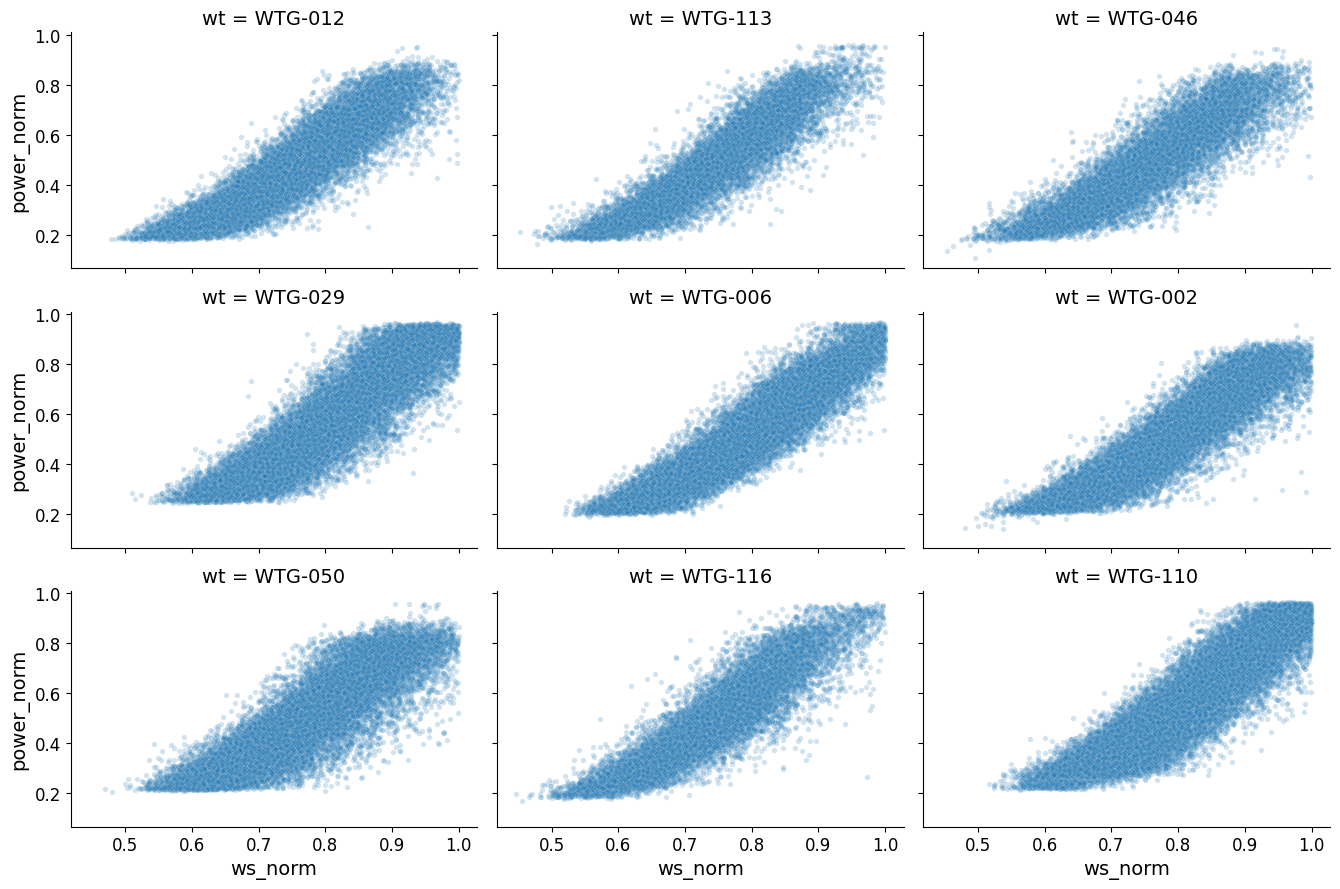

In [4]:
data = (
    ds
    .where(ds['is_analysis'])
    .sel(wt=np.random.choice(
        ds['wt'].data,
        size=9,
        replace=False,
    ))
    .to_dataframe()
    .dropna()
    .reset_index()
)
data

g = sns.relplot(
    kind='scatter',
    data=data,
    x='ws_norm',
    y='power_norm',
    col='wt',
    col_wrap=3,
    height=3,
    aspect=1.5,
    s=15,
    alpha=.2,
)

## Set up the Model

## Fit Model

In [5]:

features = ['ws_corr', 'ti', 'temp_amb_cons', 'yaw_err_center']
target = 'power_norm'

gp_kw = dict(
    n_pts=150,
    # objective='elbo',
    preprocessor=StandardScaler(),
    n_epochs=150,

)


wt = 'WTG-115'
turbines = list(ds['wt'].values)
models = {}
for n, wt in enumerate(turbines):
    logger.info(f'Fitting model for turbines: {wt} ({n + 1:3d} of {len(turbines)})')
    df = (
        ds
        .where(ds['time'] < pd.Timestamp('2023-01-31'), drop=True)
        .where(ds['is_analysis'])
        .sel(wt=wt)
        .to_dataframe()
        .dropna()
        .reset_index()
    )
    df

    train_df = resample_df(
        df,
        n_samples=5000,
        strat_col='yaw_err_center'
    )

    
    model = SparseHSGPRegressor.from_dict(gp_kw)
    model.fit(
        train_df[features].values,
        train_df[target].values
    )
    models[wt] = model


11:45:49 INFO: Fitting model for turbines: WTG-001 (  1 of 116)
11:45:54 INFO: Iter 50 of 150 - Loss: -1.1290429830551147
11:45:55 INFO: Iter 100 of 150 - Loss: -1.2804205417633057
11:45:56 INFO: Iter 150 of 150 - Loss: -1.296417236328125
11:45:56 INFO: Fitting model for turbines: WTG-002 (  2 of 116)
11:45:59 INFO: Iter 50 of 150 - Loss: -1.4016177654266357
11:46:00 INFO: Iter 100 of 150 - Loss: -1.4661189317703247
11:46:01 INFO: Iter 150 of 150 - Loss: -1.4718281030654907
11:46:01 INFO: Fitting model for turbines: WTG-003 (  3 of 116)
11:46:04 INFO: Iter 50 of 150 - Loss: -1.3626699447631836
11:46:05 INFO: Iter 100 of 150 - Loss: -1.4182946681976318
11:46:06 INFO: Iter 150 of 150 - Loss: -1.4241474866867065
11:46:06 INFO: Fitting model for turbines: WTG-004 (  4 of 116)
11:46:09 INFO: Iter 50 of 150 - Loss: -1.393020749092102
11:46:10 INFO: Iter 100 of 150 - Loss: -1.4455904960632324
11:46:11 INFO: Iter 150 of 150 - Loss: -1.452247977256775
11:46:11 INFO: Fitting model for turbines: 

## Predictions

In [6]:
from itertools import product

ws = [6, 7, 9]
ti = [0.16]
temp = [11]
dyaw = np.linspace(-7.5, 7.5, 101)

X = np.array(list(product(ws, ti, temp, dyaw)))


predicitons = []
for n, (wt, model) in enumerate(models.items()):
    logger.info(f'Make prediction for turbine {wt} ({n + 1:3d} of {len(models)})')

    
    y = model.predict(X)
    _X = X.copy()
    _X[:, -1] = 0
    y0 = model.predict(_X)
    predicitons.append(y / y0)


pred_da = (
    xr.concat(
        [
            xr.DataArray(
                data=pred,
                name='power_ratio',
                dims='ind',
                coords={
                    key: ('ind', X[:, k])
                    for k, key in enumerate(features)
                }
            )
            for pred in predicitons
        ],
        dim='wt'
    )
    .assign_coords(wt=('wt', list(models.keys())))
)
pred_da

11:56:59 INFO: Make prediction for turbine WTG-001 (  1 of 116)
11:56:59 INFO: Make prediction for turbine WTG-002 (  2 of 116)
11:56:59 INFO: Make prediction for turbine WTG-003 (  3 of 116)
11:56:59 INFO: Make prediction for turbine WTG-004 (  4 of 116)
11:56:59 INFO: Make prediction for turbine WTG-005 (  5 of 116)
11:56:59 INFO: Make prediction for turbine WTG-006 (  6 of 116)
11:56:59 INFO: Make prediction for turbine WTG-007 (  7 of 116)
11:56:59 INFO: Make prediction for turbine WTG-008 (  8 of 116)
11:56:59 INFO: Make prediction for turbine WTG-009 (  9 of 116)
11:56:59 INFO: Make prediction for turbine WTG-010 ( 10 of 116)
11:56:59 INFO: Make prediction for turbine WTG-011 ( 11 of 116)
11:56:59 INFO: Make prediction for turbine WTG-012 ( 12 of 116)
11:56:59 INFO: Make prediction for turbine WTG-013 ( 13 of 116)
11:56:59 INFO: Make prediction for turbine WTG-014 ( 14 of 116)
11:56:59 INFO: Make prediction for turbine WTG-015 ( 15 of 116)
11:56:59 INFO: Make prediction for turbi

<xarray.DataArray 'power_ratio' (wt: 116, ind: 303)> Size: 141kB
array([[0.99880177, 0.9965743 , 0.99451405, ..., 0.87901956, 0.8751846 ,
        0.8713842 ],
       [0.9778174 , 0.9708796 , 0.964499  , ..., 0.9337368 , 0.9305564 ,
        0.9272729 ],
       [0.98321897, 0.9793851 , 0.97613347, ..., 0.8945558 , 0.8872702 ,
        0.87983143],
       ...,
       [0.95778346, 0.95334077, 0.9493071 , ..., 0.90292645, 0.8969028 ,
        0.8907613 ],
       [0.9955292 , 0.9900621 , 0.98490447, ..., 0.93170923, 0.9280093 ,
        0.92421603],
       [1.0130279 , 1.0037086 , 0.9948859 , ..., 0.83954024, 0.8355295 ,
        0.8315216 ]], shape=(116, 303), dtype=float32)
Coordinates:
  * wt              (wt) <U7 3kB 'WTG-001' 'WTG-002' ... 'WTG-117' 'WTG-118'
    ws_corr         (ind) float64 2kB 6.0 6.0 6.0 6.0 6.0 ... 9.0 9.0 9.0 9.0
    ti              (ind) float64 2kB 0.16 0.16 0.16 0.16 ... 0.16 0.16 0.16
    temp_amb_cons   (ind) float64 2kB 11.0 11.0 11.0 11.0 ... 11.0 11.0 11.0
    yaw_err_center  (ind) float64 2kB -7.5 -7.35 -7.2 -7.05 ... 7.2 7.35 7.5
Dimensions without coordinates: ind

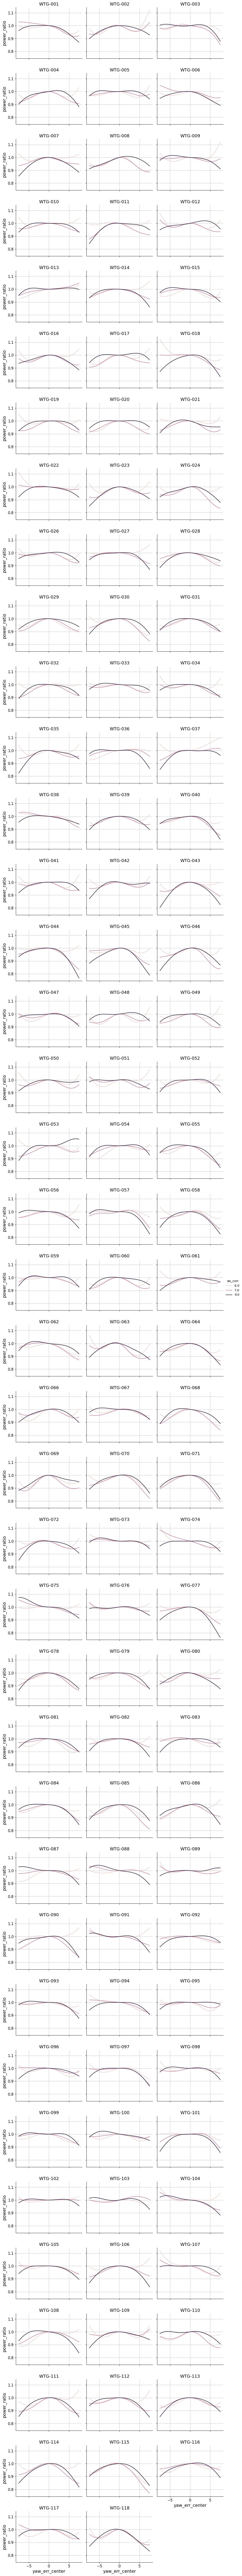

In [18]:
data = (
    pred_da
    .to_dataframe()
    .reset_index()
)

g = sns.relplot(
    kind='line',
    data=data,
    x='yaw_err_center',
    y='power_ratio',
    hue='ws_corr',
    col='wt',
    col_wrap=3,
    height=3,
    aspect=1.15,
)

g.set_titles(template='{col_name}')
for ax in g.axes.flatten():
    ax.grid(ls='--')
    

## Sandbox

In [8]:
test_df = (
    ds
    .where(ds['time'] <= pd.Timestamp('2022-07-01'), drop=True)
    .where(ds['is_analysis'])
    .sel(wt=wt)
    .to_dataframe()
    .dropna()
    .reset_index()
)
test_df
y_test = test_df[target]
y_pred = model.predict(test_df[features])

c:\Users\pcja001\git\pygp-sandbox\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [9]:
from gp_sand.utils import compute_rmse, compute_rmse_norm

print(
    compute_rmse(y_pred, y_test),
    compute_rmse_norm(y_pred, y_test),
)

0.07927962109562921 45.30454007097606


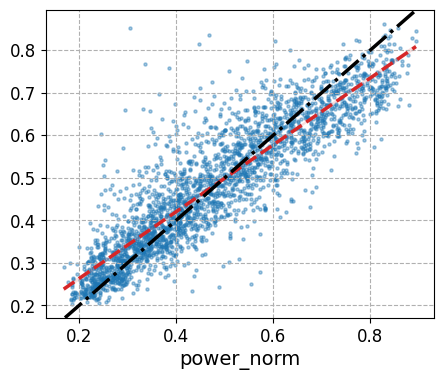

In [10]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.grid(ls='--')


# ax.plot(x_test, np.cos(np.deg2rad(x_test.numpy()))**3, ls='--', c='r')
sns.regplot(
    x=y_test,
    y=y_pred,
    # y=mean,
    scatter_kws=dict(
        s=5,
        alpha=.4,
        # edgecolor='.7'
    ),
    line_kws=dict(
        ls='--',
        lw=2.5,
        color='tab:red',
    )
)

ax.axline((.5, .5), slope=1, lw=2.5, ls='-.', c='k')

<Axes: xlabel='ws_norm', ylabel='power_norm'>

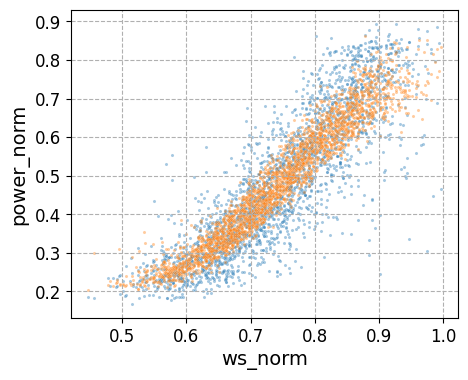

In [11]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.grid(ls='--')


# ax.plot(x_test, np.cos(np.deg2rad(x_test.numpy()))**3, ls='--', c='r')
sns.scatterplot(x=test_df['ws_norm'], y=test_df['power_norm'], s=5, alpha=.4, color='tab:blue')
sns.scatterplot(x=test_df['ws_norm'], y=y_pred, s=5, alpha=.4, color='tab:orange')


In [12]:
ws = (
    test_df['ws_corr']
    .pipe(lambda s: (
        np.linspace(*np.percentile(s, [0, 100]), 21)
    ))
)
ti = np.ones_like(ws) * 1.24
temp = np.ones_like(ws) * 11
dyaw = np.zeros_like(ws)

X = np.stack([ws, ti, temp, dyaw], axis=1)
X = model.preprocessor.transform(X)

with torch.no_grad():
    f_dist = model.model(torch.tensor(X).to(torch.float32))

    y = f_dist.mean
    
    f_lower, f_upper = f_dist.confidence_region()
    # y_dist = likelihood(f_dist)
    # y_lower, y_upper = y_dist.confidence_region()

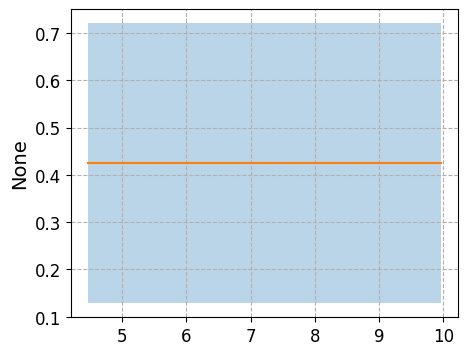

In [13]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.grid(ls='--')


# ax.plot(x_test, np.cos(np.deg2rad(x_test.numpy()))**3, ls='--', c='r')
# sns.scatterplot(x=ws, y=test_df['power_norm'], s=5, alpha=.4, color='tab:blue')
sns.lineplot(x=ws, y=y, color='tab:orange')
ax.fill_between(ws, f_lower, f_upper, alpha=0.3, label="q(f)")


<Axes: xlabel='ws_corr', ylabel='power_norm'>

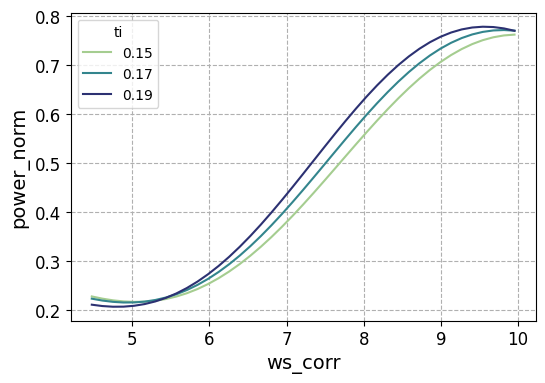

In [14]:
from itertools import product

ws = (
    test_df['ws_corr']
    .pipe(lambda s: (
        np.linspace(*np.percentile(s, [0, 100]), 41)
    ))
)
ti = (
    test_df['ti']
    .pipe(lambda s: (
        np.linspace(*np.percentile(s, [25, 75]), 3)
    ))
    .round(2)
)
# ti = (ws_std / ws).round(2)
temp = 11
dyaw = 0

X = np.array(list(product(ws, ti, [temp], [dyaw])))
_X = model.preprocessor.transform(X)

with torch.no_grad():
    f_dist = model.model(torch.tensor(_X).to(torch.float32))

    y = f_dist.mean
    
    f_lower, f_upper = f_dist.confidence_region()
    # y_dist = likelihood(f_dist)
    # y_lower, y_upper = y_dist.confidence_region()

data = pd.DataFrame(
    data=np.concat([X, y.numpy()[:, None],], axis=1),
    columns=features + [target]
)
# data = data.assign(ti=(data['ws_std_corr'] / data['ws_corr']).round(3))

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

sns.lineplot(
    data=data,
    x='ws_corr',
    y=target,
    hue='ti',
    lw=1.5,
    palette='crest'
)

<Axes: xlabel='ws_corr', ylabel='power_norm'>

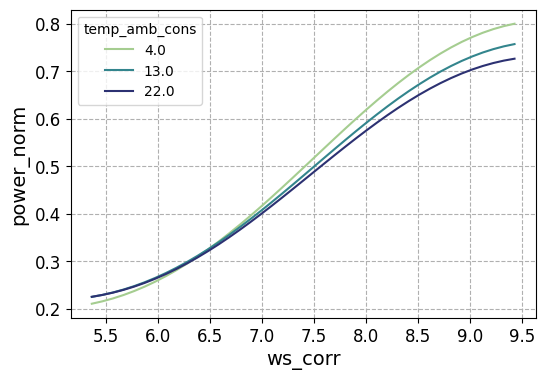

In [15]:
from itertools import product

ws = (
    test_df['ws_corr']
    .pipe(lambda s: (
        np.linspace(*np.percentile(s, [1.5, 98.5]), 41)
    ))
)
ti = test_df['ti'].mean().item()
# ti = (ws_std / ws).round(2)
temp = (
    test_df['temp_amb_cons']
    .pipe(lambda s: (
        np.linspace(*np.percentile(s, [25, 75]), 3)
    ))
    .round(0)
)
dyaw = 0

X = np.array(list(product(ws, [ti], temp, [dyaw])))
_X = model.preprocessor.transform(X)

with torch.no_grad():
    f_dist = model.model(torch.tensor(_X).to(torch.float32))

    y = f_dist.mean
    
    f_lower, f_upper = f_dist.confidence_region()
    # y_dist = likelihood(f_dist)
    # y_lower, y_upper = y_dist.confidence_region()

data = pd.DataFrame(
    data=np.concat([X, y.numpy()[:, None],], axis=1),
    columns=features + [target]
)
# data = data.assign(ti=(data['ws_std_corr'] / data['ws_corr']).round(3))

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

sns.lineplot(
    data=data,
    x='ws_corr',
    y=target,
    hue='temp_amb_cons',
    lw=1.5,
    palette='crest'
)

<Axes: xlabel='yaw_err_center', ylabel='power_ratio'>

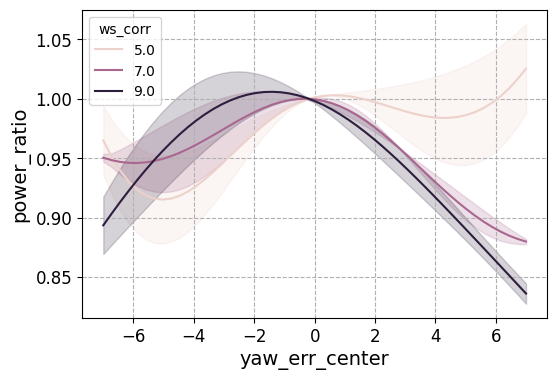

In [16]:
dyaw = np.linspace(-7, 7, 51)
ws = np.linspace(5, 9, 3)
ti = (
    test_df['ti']
    .pipe(lambda s: (
        np.linspace(*np.percentile(s, [25, 75]), 3)
    ))
    .round(2)
)
temp=11

X = np.array(list(product(ws, ti, [temp], dyaw)))
_X = model.preprocessor.transform(X)

with torch.no_grad():
    f_dist = model.model(torch.tensor(_X).to(torch.float32))

    # Get the power
    y = f_dist.mean.numpy()[:, None]

    # Get aligned power
    _X[:, -1] = 0
    f_dist = model.model(torch.tensor(_X).to(torch.float32))
    y0 = f_dist.mean.numpy()[:, None]
    
    f_lower, f_upper = f_dist.confidence_region()
    # y_dist = likelihood(f_dist)
    # y_lower, y_upper = y_dist.confidence_region()

data = pd.DataFrame(
    data=np.concat([X, y, y0, y / y0], axis=1),
    columns=features + [target, 'power_aligned', 'power_ratio']
)
# data = data.assign(ti=(data['ws_std_corr'] / data['ws_corr']).round(3))

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

sns.lineplot(
    data=data,
    x='yaw_err_center',
    y='power_ratio',
    hue='ws_corr',
    lw=1.5,
    # palette='crest',
    errorbar='sd'
)

In [ ]:
wt = 'WTG-075'
features = [
    'ws_corr',
    'ti',
    'temp_amb_cons',
    # 'yaw_err_center'
]


times = pd.date_range(
    pd.to_datetime(ds['time']).min(),
    pd.Timestamp('2022-07-01'),
    freq='10min',
)
df = (
    ds
    .sel(time=list(set(times).intersection(ds['time'].data)))
    .pipe(lambda ds: (
        ds.assign(
            is_analysis=(
                ds['normal_op']
                & ds['no_close_wake']
                & ds['is_steady_prod']
                & (ds['gen_speed_norm'] <= 0.95)
                & (.2 <= ds['gen_speed_norm'])
                & (ds['ws_corr'] <= 10)
                # & (np.abs(ds['yaw_err_center']) <= .5)
            )
        )
    ))
    .pipe(lambda ds: ds.where(ds['is_analysis']))
    .sel(wt=wt)
    .to_dataframe()
    .dropna()
    .reset_index()
)
df

model = SparseHSGPRegressor(
    n_pts=150,
    preprocessor=StandardScaler(),
    n_epochs=150,
)

model.fit(df[features].values, df[target].values)

07:50:11 INFO: Iter 50 of 150 - Loss: -1.4736387729644775
07:50:12 INFO: Iter 100 of 150 - Loss: -1.4961808919906616
07:50:14 INFO: Iter 150 of 150 - Loss: -1.508365511894226


c:\Users\pcja001\git\pygp-sandbox\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


<Axes: xlabel='yaw_err_center', ylabel='power_ratio'>

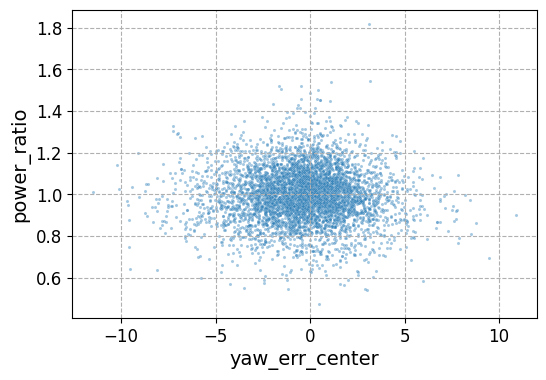

In [231]:
pred = model.predict(df[features])
df['pred'] = pred
df['power_ratio'] = df[target] / pred

data = df

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

sns.scatterplot(
    data=data,
    x='yaw_err_center',
    y='power_ratio',
    s=5,
    alpha=.4,
)

<Axes: xlabel='yaw_err_center', ylabel='power_ratio'>

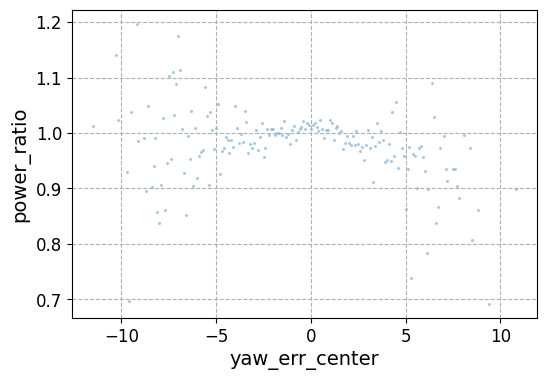

In [232]:
data = (
    df
    .pipe(lambda df: (
        df.assign(
            yaw_err_center=(
                (df['yaw_err_center'] // .1) * 0.1
            )
        )
    ))
    [['yaw_err_center', 'power_ratio']]
    .groupby('yaw_err_center')
    .mean()
    .reset_index()
)

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

sns.scatterplot(
    data=data,
    x='yaw_err_center',
    y='power_ratio',
    s=5,
    alpha=.4,
)

07:29:03 INFO: Iter 50 of 250 - Loss: 84.67005920410156
07:29:04 INFO: Iter 100 of 250 - Loss: 81.43285369873047
07:29:05 INFO: Iter 150 of 250 - Loss: 1.5286462306976318
07:29:06 INFO: Iter 200 of 250 - Loss: -0.45528197288513184
07:29:06 INFO: Iter 250 of 250 - Loss: -0.4566236138343811


<Axes: >

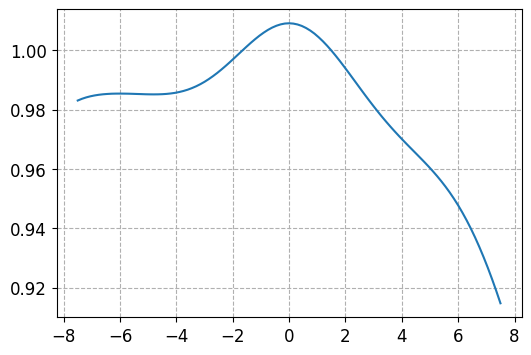

In [233]:
# df = data



model = SparseHSGPRegressor(
    n_pts=125,
    objective='elbo',
    preprocessor=StandardScaler(),
    n_epochs=250,
)

model.fit(df[['yaw_err_center']].values, df['power_ratio'])


X = np.linspace(-7.5, 7.5, 101)[:, None]
pred = model.predict(X)

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

sns.lineplot(x=X.ravel(), y=pred)

In [234]:
# from


n_sub = 1000
n_experts = 30

x = np.linspace(-7.5, 7.5, 101)[:, None]
models, predicitons, dataframes = [], [], []
for n in range(n_experts):
    logger.info(f'Training expert {n + 1} (of {n_experts})')

    sub = resample_df(df, n_sub, replace=True)
    dataframes.append(sub)
    model = SparseHSGPRegressor(
        n_pts = 101,
        preprocessor=StandardScaler(),
        n_epochs=150,
    )
    model.fit(sub[['yaw_err_center']].values, sub['power_ratio'])
    models.append(model)
    predicitons.append(model.predict(x))

07:29:07 INFO: Training expert 1 (of 30)
07:29:07 INFO: Iter 50 of 150 - Loss: -0.6561889052391052
07:29:08 INFO: Iter 100 of 150 - Loss: -0.6722801327705383
07:29:08 INFO: Iter 150 of 150 - Loss: -0.6753390431404114
07:29:08 INFO: Training expert 2 (of 30)
07:29:09 INFO: Iter 50 of 150 - Loss: -0.6479660272598267
07:29:09 INFO: Iter 100 of 150 - Loss: -0.6673192381858826
07:29:10 INFO: Iter 150 of 150 - Loss: -0.6711438894271851
07:29:10 INFO: Training expert 3 (of 30)
07:29:10 INFO: Iter 50 of 150 - Loss: -0.6371312737464905
07:29:10 INFO: Iter 100 of 150 - Loss: -0.6597854495048523
07:29:11 INFO: Iter 150 of 150 - Loss: -0.6639912724494934
07:29:11 INFO: Training expert 4 (of 30)
07:29:11 INFO: Iter 50 of 150 - Loss: -0.6136792302131653
07:29:12 INFO: Iter 100 of 150 - Loss: -0.6335619688034058
07:29:12 INFO: Iter 150 of 150 - Loss: -0.63688063621521
07:29:12 INFO: Training expert 5 (of 30)
07:29:13 INFO: Iter 50 of 150 - Loss: -0.6809125542640686
07:29:13 INFO: Iter 100 of 150 - Lo

<Axes: xlabel='dyaw', ylabel='power_ratio'>

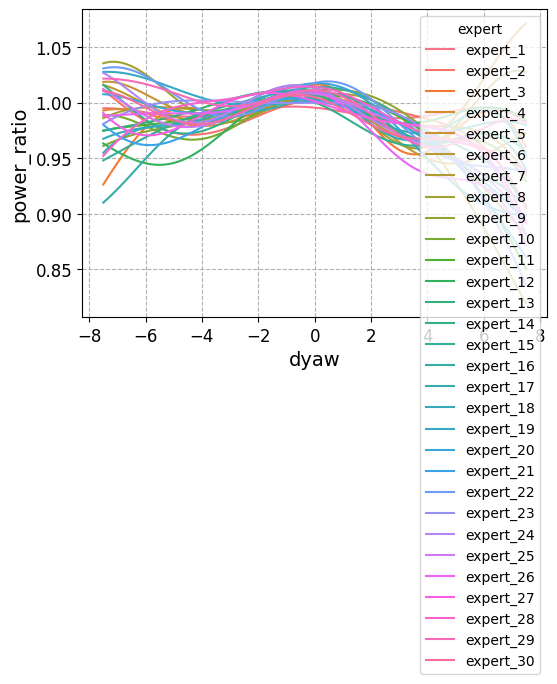

In [235]:
data = (
    pd.DataFrame(
        data=np.stack(
            predicitons,
            axis=1
        ),
        columns=pd.Index(
            data=[
                f'expert_{n + 1}'
                for n in range(n_experts)
            ],
            name='expert'
        ),
        index=pd.Index(x.ravel(), name='dyaw')
    )
    .stack()
    .rename('power_ratio')
    .reset_index()
)
data

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

sns.lineplot(
    data=data,
    x='dyaw',
    y='power_ratio',
    hue='expert',
)

<Axes: xlabel='dyaw', ylabel='power_ratio'>

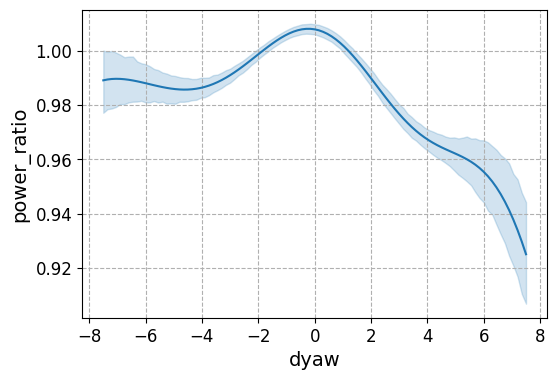

In [236]:

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

sns.lineplot(
    data=data,
    x='dyaw',
    y='power_ratio',
    # hue='expert',
)

In [305]:
wt = 'WTG-115'
features = [
    'ws_corr',
    'ti',
    'temp_amb_cons',
    # 'yaw_err_center'
]


times = pd.date_range(
    pd.to_datetime(ds['time']).min(),
    pd.Timestamp('2022-07-01'),
    freq='10min',
)
df = (
    ds
    .sel(time=list(set(times).intersection(ds['time'].data)))
    .pipe(lambda ds: (
        ds.assign(
            is_analysis=(
                ds['normal_op']
                & ds['no_close_wake']
                & ds['is_steady_prod']
                & (ds['gen_speed_norm'] <= 0.95)
                & (.2 <= ds['gen_speed_norm'])
                & (ds['ws_corr'] <= 10)
                # & (np.abs(ds['yaw_err_center']) <= .5)
            )
        )
    ))
    .pipe(lambda ds: ds.where(ds['is_analysis']))
    .sel(wt=wt)
    .to_dataframe()
    .dropna()
    .reset_index()
)
df

model = SparseHSGPRegressor(
    n_pts=150,
    preprocessor=StandardScaler(),
    n_epochs=150,
)

model.fit(df[features].values, df[target].values)

pred = model.predict(df[features])
df['pred'] = pred
df['power_ratio'] = df[target] / pred


08:20:29 INFO: Iter 50 of 150 - Loss: -1.1247026920318604
08:20:30 INFO: Iter 100 of 150 - Loss: -1.1632335186004639
08:20:31 INFO: Iter 150 of 150 - Loss: -1.1661790609359741
c:\Users\pcja001\git\pygp-sandbox\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [310]:
n_train / 10

225.3

In [334]:
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import PredictiveLogLikelihood

from sklearn.utils import resample

from torch.optim import Adam

from gp_sand.gp import _SparseGP, get_inductions_points


n_batches = 50
batch_size = 0.8
# n_epochs = 5
X = df[['yaw_err_center']].values
y = df['power_ratio'].values
scaler = StandardScaler()


X = scaler.fit_transform(X)
n_train = int(np.ceil(batch_size * y.shape[0]))
Xs, ys = [], []
rng = np.random.RandomState(4093)
for _ in range(n_batches):
    _X, _y = resample(
        *[X, y],
        n_samples=n_train,
        # replace=False,
        stratify=X[:, -1],
        random_state=rng,
    )
    Xs.append(torch.tensor(_X).to(torch.float32))
    ys.append(torch.tensor(_y).to(torch.float32))


# Set up model
model = _SparseGP(get_inductions_points(X, int(np.ceil(n_train / 10))))
likelihood = GaussianLikelihood()

# Activate train mode
model.train()
likelihood.train()

# Define optimizer
optim = Adam(
    list(model.parameters()) + list(likelihood.parameters()),
    lr=0.1
)

obj = PredictiveLogLikelihood(
    likelihood,
    model,
    num_data=n_train
)



# for n in range(n_epochs):
    # logger.info(f'Iter {n + 1} of {n_epochs}')
for n, (_X, _y) in enumerate(zip(Xs, ys)):

    optim.zero_grad()
    pred = model(_X)
    loss = - obj(pred, _y)
    loss.backward()
    optim.step()

    # Logger
    if (n + 1) % 5 == 0:
        # logger.info(f'Iter {n + 1} of {n_epochs} - Loss: {loss.item()}')
        logger.info(f'Iter {n + 1} of {n_batches} - Loss: {loss.item()}')

08:30:32 INFO: Iter 5 of 50 - Loss: 1.1118271350860596
08:30:32 INFO: Iter 10 of 50 - Loss: 0.5961241126060486
08:30:32 INFO: Iter 15 of 50 - Loss: 0.32719072699546814
08:30:32 INFO: Iter 20 of 50 - Loss: 0.09081389009952545
08:30:32 INFO: Iter 25 of 50 - Loss: -0.11183015257120132
08:30:32 INFO: Iter 30 of 50 - Loss: -0.2593737840652466
08:30:32 INFO: Iter 35 of 50 - Loss: -0.32947856187820435
08:30:32 INFO: Iter 40 of 50 - Loss: -0.33354395627975464
08:30:33 INFO: Iter 45 of 50 - Loss: -0.33491992950439453
08:30:33 INFO: Iter 50 of 50 - Loss: -0.34341496229171753


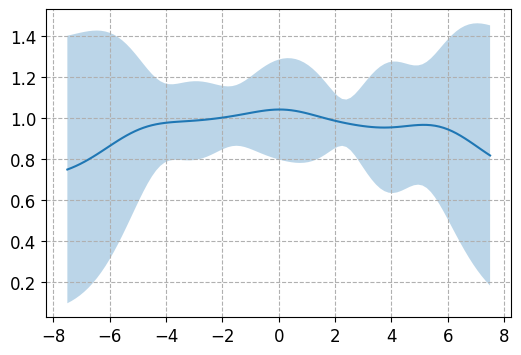

In [335]:
X = np.linspace(-7.5, 7.5, 101)[:, None]
X = torch.tensor(X).to(torch.float32)
with torch.no_grad():
    f_dist = model(X)
    pred = f_dist.mean.numpy()
    f_lower, f_upper = f_dist.confidence_region()
    y_dist = likelihood(f_dist)
    y_lower, y_upper = y_dist.confidence_region()

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

x = X.numpy().ravel()
sns.lineplot(x=x, y=pred)
ax.fill_between(x, f_lower, f_upper, alpha=0.3)

In [338]:
np.random.RandomState(6).choice(turbines, 24, replace=False)

array(['WTG-073', 'WTG-017', 'WTG-001', 'WTG-106', 'WTG-021', 'WTG-036',
       'WTG-099', 'WTG-024', 'WTG-063', 'WTG-041', 'WTG-057', 'WTG-055',
       'WTG-060', 'WTG-048', 'WTG-067', 'WTG-034', 'WTG-097', 'WTG-049',
       'WTG-056', 'WTG-046', 'WTG-095', 'WTG-029', 'WTG-040', 'WTG-032'],
      dtype='<U7')

In [341]:
from gp_sand.gp import BatchedSparseHSGPRegressor


features = [
    'ws_corr',
    'ti',
    'temp_amb_cons',
    # 'yaw_err_center'
]
target = 'power_norm'

gp_kw = dict(
    n_pts=150,
    # objective='elbo',
    preprocessor=StandardScaler(),
    n_epochs=150,

)


wt = 'WTG-115'
turbines = list(ds['wt'].values)
turbines = np.random.RandomState(6).choice(turbines, 24, replace=False)
models_pw, model_ratio = {}, {}
for n, wt in enumerate(turbines):
    logger.info(f'Fitting model for turbines: {wt} ({n + 1:3d} of {len(turbines)})')
    df = (
        ds
        .sel(time=list(set(times).intersection(ds['time'].data)))
        .pipe(lambda ds: (
            ds.assign(
                is_analysis=(
                    ds['normal_op']
                    & ds['no_close_wake']
                    & ds['is_steady_prod']
                    & (ds['gen_speed_norm'] <= 0.95)
                    & (.2 <= ds['gen_speed_norm'])
                    & (ds['ws_corr'] <= 10)
                    # & (np.abs(ds['yaw_err_center']) <= .5)
                )
            )
        ))
        .pipe(lambda ds: ds.where(ds['is_analysis']))
        .sel(wt=wt)
        .to_dataframe()
        .dropna()
        .reset_index()
    )
    df

    
    model = SparseHSGPRegressor(
        n_pts=150,
        preprocessor=StandardScaler(),
        n_epochs=150,
    )

    model.fit(df[features].values, df[target].values)
    models_pw[wt] = model

    pred = model.predict(df[features])
    df['pred'] = pred
    df['power_ratio'] = df[target] / pred

    
    model = BatchedSparseHSGPRegressor(
        n_pts=150,
        n_batches=50,
        batch_size=0.8,
        preprocessor=StandardScaler()
    )
    model.fit(df[['yaw_err_center']].values, df['power_ratio'].values)
    model_ratio[wt] = model

08:36:02 INFO: Fitting model for turbines: WTG-073 (  1 of 24)
08:36:04 INFO: Iter 50 of 150 - Loss: -1.4937413930892944
08:36:06 INFO: Iter 100 of 150 - Loss: -1.5625174045562744
08:36:07 INFO: Iter 150 of 150 - Loss: -1.5503495931625366
c:\Users\pcja001\git\pygp-sandbox\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
08:36:07 INFO: Generate training batch
08:36:09 INFO: Start training.
08:36:10 INFO: Iter 50 of 50 - Loss: -0.7027024626731873
08:36:10 INFO: Fitting model for turbines: WTG-017 (  2 of 24)
08:36:12 INFO: Iter 50 of 150 - Loss: -1.3119350671768188
08:36:13 INFO: Iter 100 of 150 - Loss: -1.3359075784683228
08:36:14 INFO: Iter 150 of 150 - Loss: -1.3510130643844604
c:\Users\pcja001\git\pygp-sandbox\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
08:36

In [344]:
from itertools import product

ws = [6, 7, 9]
ti = [0.16]
temp = [11]
dyaw = np.linspace(-7.5, 7.5, 101)

X = np.linspace(-7.5, 7.5, 101)[:, None]


predicitons = []
for n, (wt, model) in enumerate(model_ratio.items()):
    logger.info(f'Make prediction for turbine {wt} ({n + 1:3d} of {len(models)})')

    
    y = model.predict(X)
    predicitons.append(y)


pred_da = (
    xr.concat(
        [
            xr.DataArray(
                data=pred,
                name='power_ratio',
                dims='ind',
                coords={
                    key: ('ind', X[:, k])
                    for k, key in enumerate(range(X.shape[1]))
                }
            )
            for pred in predicitons
        ],
        dim='wt'
    )
    .assign_coords(wt=('wt', list(model_ratio.keys())))
)
pred_da

08:39:29 INFO: Make prediction for turbine WTG-073 (  1 of 30)
08:39:29 INFO: Make prediction for turbine WTG-017 (  2 of 30)
08:39:29 INFO: Make prediction for turbine WTG-001 (  3 of 30)
08:39:29 INFO: Make prediction for turbine WTG-106 (  4 of 30)
08:39:29 INFO: Make prediction for turbine WTG-021 (  5 of 30)
08:39:29 INFO: Make prediction for turbine WTG-036 (  6 of 30)
08:39:29 INFO: Make prediction for turbine WTG-099 (  7 of 30)
08:39:29 INFO: Make prediction for turbine WTG-024 (  8 of 30)
08:39:29 INFO: Make prediction for turbine WTG-063 (  9 of 30)
08:39:29 INFO: Make prediction for turbine WTG-041 ( 10 of 30)
08:39:29 INFO: Make prediction for turbine WTG-057 ( 11 of 30)
08:39:29 INFO: Make prediction for turbine WTG-055 ( 12 of 30)
08:39:29 INFO: Make prediction for turbine WTG-060 ( 13 of 30)
08:39:29 INFO: Make prediction for turbine WTG-048 ( 14 of 30)
08:39:29 INFO: Make prediction for turbine WTG-067 ( 15 of 30)
08:39:29 INFO: Make prediction for turbine WTG-034 ( 16

<xarray.DataArray 'power_ratio' (wt: 24, ind: 101)> Size: 10kB
array([[1.0086505 , 1.0093901 , 1.0100288 , ..., 0.96966326, 0.9703728 ,
        0.97103214],
       [0.97220206, 0.9715135 , 0.9709532 , ..., 0.9740566 , 0.9736279 ,
        0.97305536],
       [1.002357  , 1.0035195 , 1.0045471 , ..., 0.97654116, 0.97656703,
        0.9765572 ],
       ...,
       [0.97765064, 0.9793827 , 0.9809686 , ..., 0.9861193 , 0.9877293 ,
        0.98924243],
       [0.9754664 , 0.977219  , 0.97881454, ..., 0.9471611 , 0.94482964,
        0.94239575],
       [0.99806964, 0.9996997 , 1.0011992 , ..., 0.9506317 , 0.9493118 ,
        0.9477855 ]], shape=(24, 101), dtype=float32)
Coordinates:
  * wt       (wt) <U7 672B 'WTG-073' 'WTG-017' 'WTG-001' ... 'WTG-040' 'WTG-032'
    0        (ind) float64 808B -7.5 -7.35 -7.2 -7.05 -6.9 ... 7.05 7.2 7.35 7.5
Dimensions without coordinates: ind

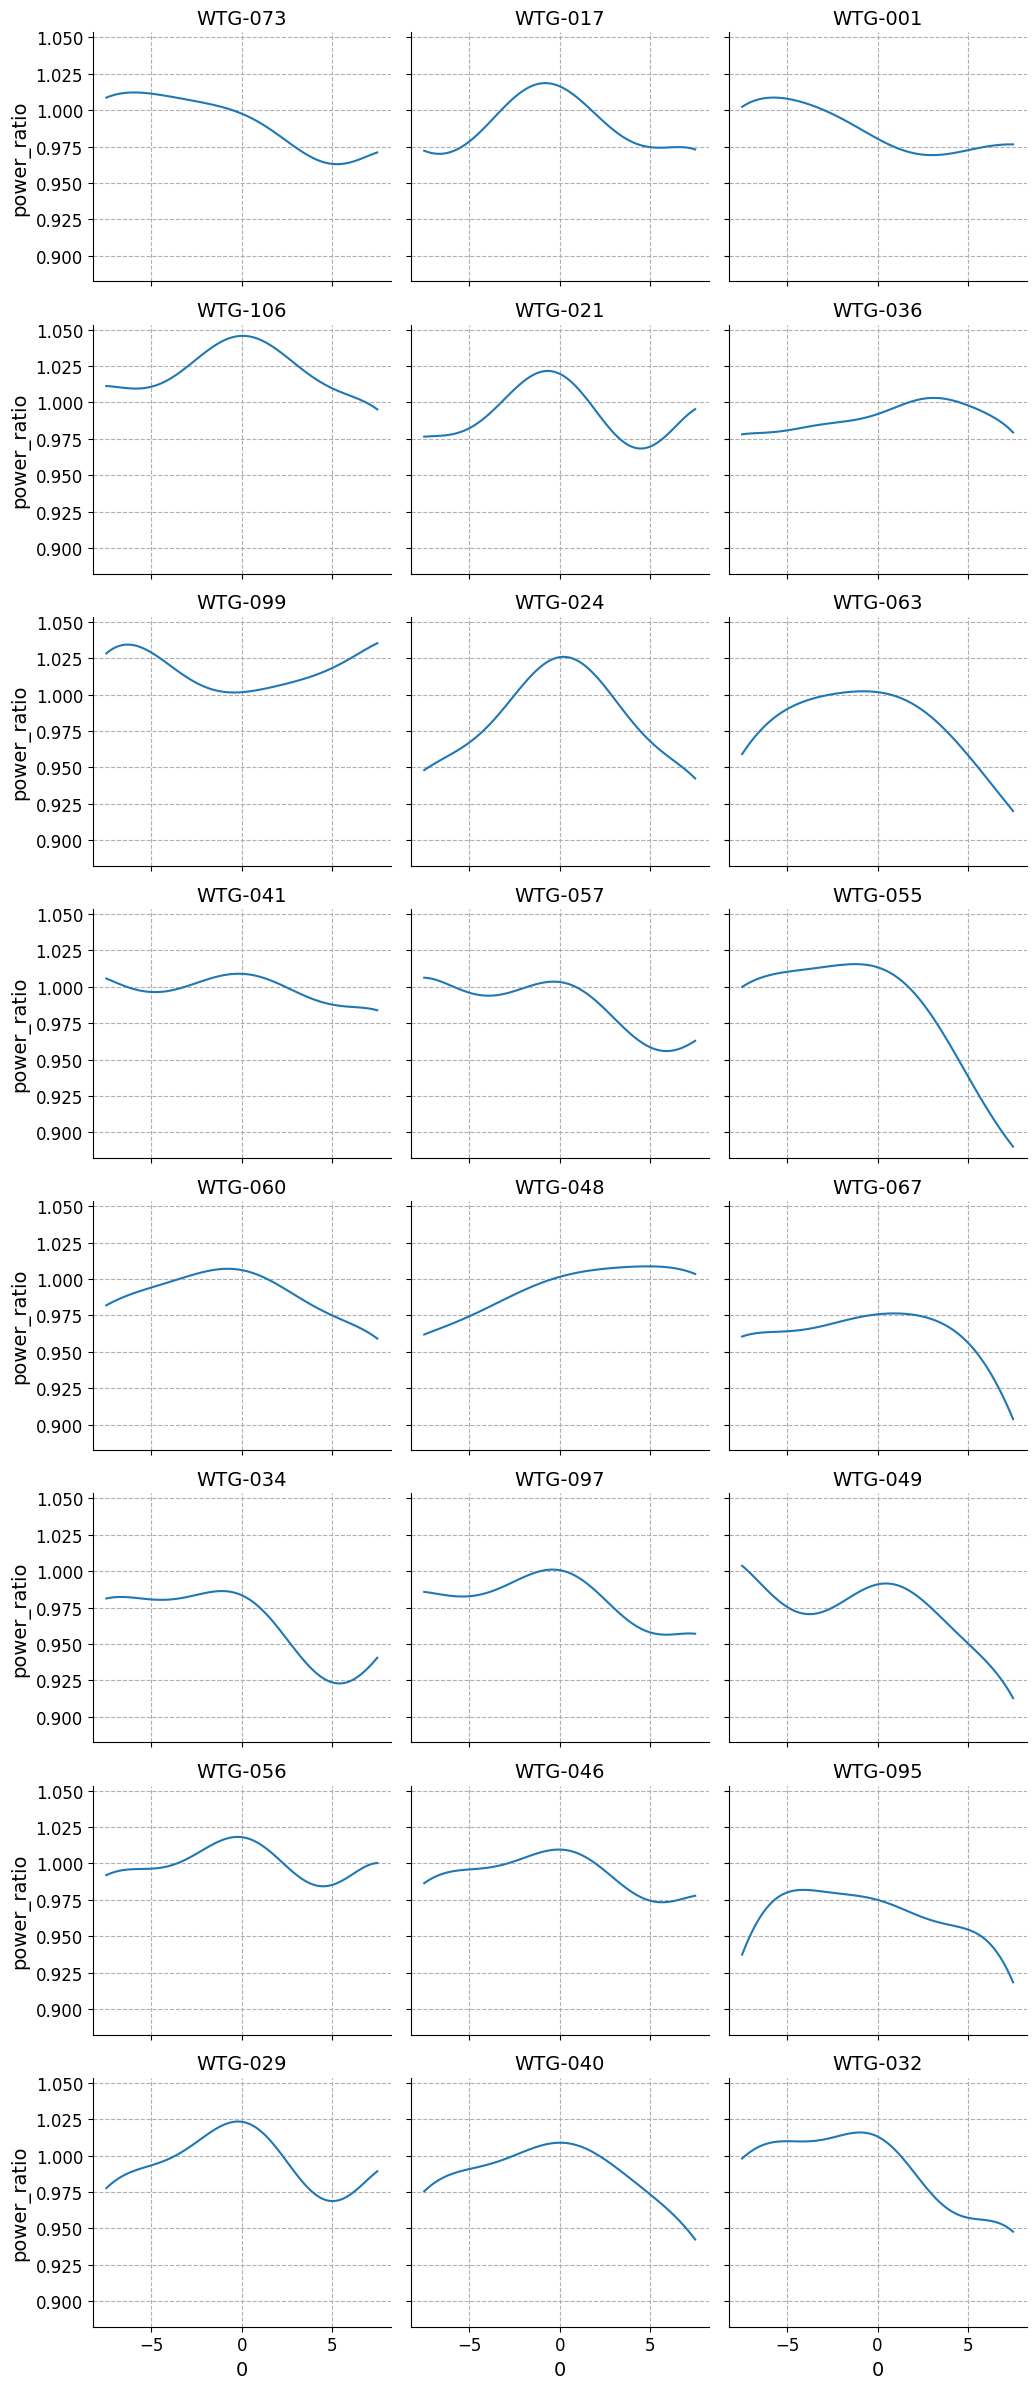

In [350]:
data = (
    pred_da
    .to_dataframe()
    .reset_index()
)
data

g = sns.relplot(
    kind='line',
    data=data,
    x=0,
    y='power_ratio',
    # hue='ws_corr',
    col='wt',
    col_wrap=3,
    height=3,
    aspect=1.15,
)

g.set_titles(template='{col_name}')
for ax in g.axes.flatten():
    ax.grid(ls='--')
    